In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import time
import sklearn.decomposition as skdec

import scipy
import sys
import os
from pytictoc import TicToc
import matplotlib
import h5py

from scipy.stats import gamma
from scipy.optimize import curve_fit
from scipy import optimize

sys.path.append('/home/moro/git_stuffs/SpeckledFluoImagingAnalisys/')
import speckle_stuffs as spkstf
from moro_utils import eprint

import pickle

In [12]:
def gamma_speckles(I, I0, scale, N):
    """Returns the gamma function which define the intensity distribution of 
    the speckle generated by multiple uncoherent speckles, as described in Goodman eq.3.94"""
    # introduce A and xscale since what is given will not be necessarly a pdf
    return gamma.pdf((I/I0), N)/(1/(I0*scale))

def fit_speckle_statistics(frame, out_plot=True, out_fig='', bins = 40, ax = None):
    """fit the intensity statistics with a gamma distribution 
    and try to guess the independent speckles/degrees of freedom
    
    out_plot = bool : if set show the fits done for the analisys
    bins = int : set the binning used to calculate the distribution
    """
    frame_contrast = np.std(frame)/np.mean(frame)
    N_contrast = 1/(frame_contrast**2)    
    histogram = np.histogram(np.ravel(frame), bins)
    xxx = histogram[1][0:-1]+(histogram[1][1]-histogram[1][0])/2
    yyy = histogram[0]
    errfunc = lambda p, x, y: gamma_speckles(x, *p) - y
    scaling_factor = (np.max(frame)*bins)/np.sum(frame)
    p0 = [0.01, 100, N_contrast]

    popt, success= optimize.leastsq(errfunc, p0[:], args=(xxx, yyy))
    print("fit : N = %d, contrast = %.7f"%(popt[2],1/(np.sqrt(popt[2]))))
    if out_plot:
        ax.plot(xxx, gamma_speckles(xxx,  *popt), '-')
#         ax.plot(xxx, yyy)
        ax.hist(np.ravel(frame), bins)
        ax.set_xlim([0,1])
        if out_fig is not '':
            fig.savefig(out_fig, dpi=300)
    # return N from the fit
    return popt[2]

In [3]:
# supp figure 1
# from fig 2 dataset
picklesource = '/home/moro/localdata/39519608500622/data_25012019_002_39519608500622_762875588588056.pickle' 
# from fig 3 dataset
# picklesource = '/home/moro/localdata/154588749961840/data_23032019_all_154588749961840_1215868743061893.pickle' 

filehandler = open(picklesource, 'rb')
[extr_traces, extr_footprints, dpars] = pickle.load(filehandler)
filehandler.close()
videofile = '/home/moro/localdata/'+picklesource.split('/')[-1].split('_')[1] + os.sep+ '_'.join((picklesource.split('/')[-1]).split('_')[:3])+'.mat'
video_source = np.swapaxes(scipy.io.loadmat(videofile)['video_data'], 0, 2)

cannot import cuda libraries, filtering with the CPU...
cannot import cuda libraries, filtering with the CPU...


fit : N = 61, contrast = 0.1272026


cannot import cuda libraries, filtering with the CPU...
cannot import cuda libraries, filtering with the CPU...


fit : N = 72, contrast = 0.1176103


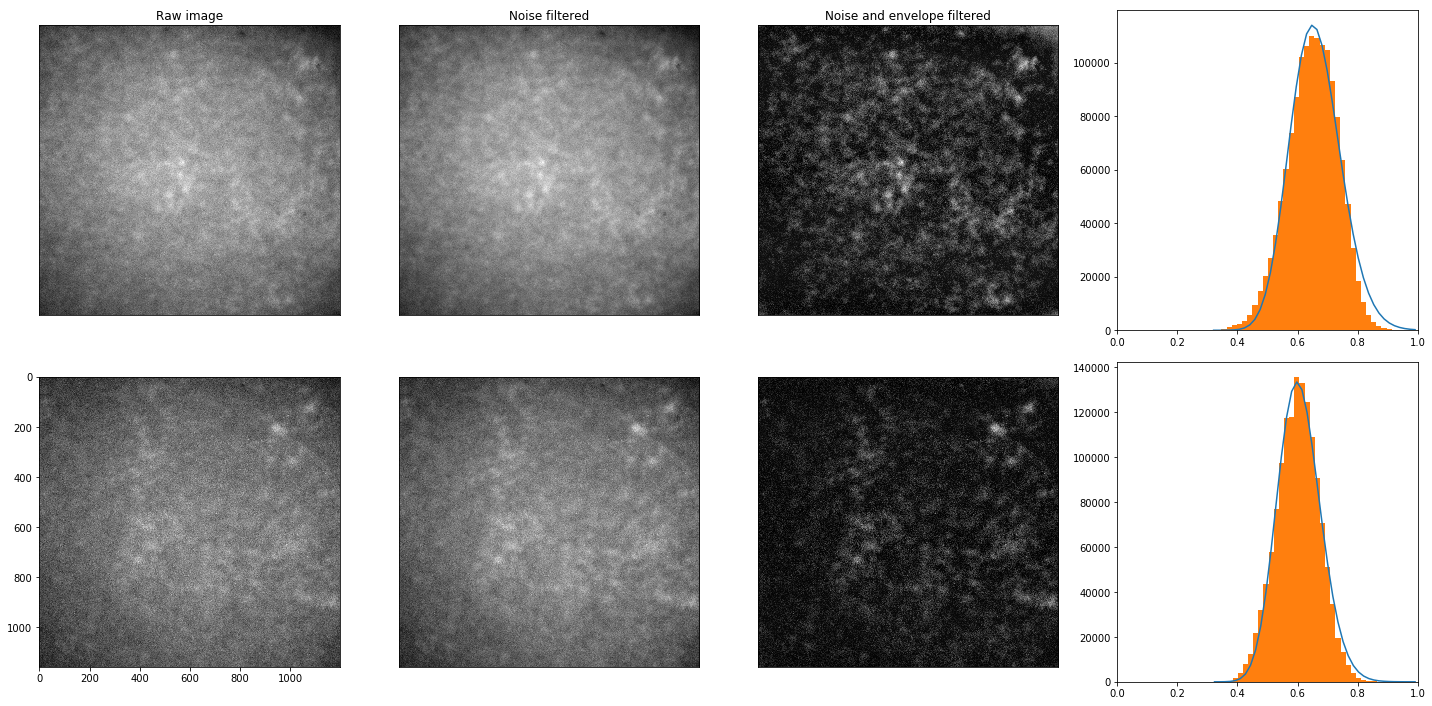

In [13]:
inde = 14
lp = dpars['lowfilter']
hp = dpars['highfilter']

cut_vs = video_source[-500:]
contrasts = np.array([spkstf.contrast(frame) for frame in cut_vs])
mn = np.mean(contrasts)
sd = np.std(contrasts)

idxs = [29, 499]


fig = plt.figure(figsize=(20, 5*len(idxs)))

for i, idx in enumerate(idxs):
    ax = fig.add_subplot(len(idxs),4,1+i*4)
#     frame = spkstf.gauss_don_filt_GPU(cut_vs[idx])
    ax.grid(False)
    if i==0: ax.set_title('Raw image')
    if i!=(len(idxs)-1): 
        ax.set_xticks([])
        ax.set_yticks([])
    ax.imshow(cut_vs[idx], cmap='gray')

    ax = fig.add_subplot(len(idxs),4,2+i*4)
    frame = spkstf.gauss_don_filt_GPU(cut_vs[idx], lp=lp)
    ax.grid(False)
    if i==0: ax.set_title('Noise filtered')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(frame, cmap='gray')

    ax = fig.add_subplot(len(idxs),4,3+i*4)
    frame = spkstf.gauss_don_filt_GPU(cut_vs[idx], hp=hp, lp=lp)
    ax.grid(False)
    if i==0: ax.set_title('Noise and envelope filtered')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(frame, cmap='gray')
    
    ax = fig.add_subplot(len(idxs),4,4+i*4)
    #     outimage = '/home/moro/Documents/stat_%d.eps'%idx/home/moro/Documents/stat_%d.eps'%idx
    outimage = ''
    frame = cut_vs[idx]
    fit_speckle_statistics(frame/np.max(frame), out_fig=outimage, ax=ax)

fig.tight_layout()
plt.show()